In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from functools import reduce
from utils import Serialization, flatten
from collections import Counter
from itertools import chain
tqdm.pandas()

In [7]:
DIR = "/ais/hal9000/datasets/reddit/stance_pipeline/nov_27_test_run/crossposting/"
files = os.listdir(DIR)
dfs = []
for file in tqdm(files):
    df = pd.read_json(DIR + file, lines=True)
    df = df[~df['author'].isin(["AutoModerator", "dollarwolf", "[deleted]", "[removed]"])]
    dfs.append(df)

100%|██████████| 12/12 [05:27<00:00, 27.32s/it]


In [9]:
author_aggs = []
for df in tqdm(dfs):
    x = df.groupby("author").agg(set)
    author_aggs.append(x)

100%|██████████| 12/12 [04:24<00:00, 22.04s/it]


In [11]:
author_dub_aggs = []
for df in tqdm(dfs):
    df['fake'] = 1
    x = df.groupby(["author", "subreddit"]).count()
    author_dub_aggs.append(x)

100%|██████████| 12/12 [01:47<00:00,  9.00s/it]


In [12]:
a, b = author_dub_aggs[0], author_dub_aggs[1]

In [20]:
full = reduce(lambda a, b: a.add(b, fill_value=0), tqdm(author_dub_aggs))

100%|██████████| 12/12 [06:16<00:00, 31.39s/it]


In [23]:
agg = full.groupby("author").count()

In [24]:
valid_authors = agg[agg["fake"] > 1].index

In [30]:
new = full[full.index.get_level_values(0).isin(valid_authors)]

In [3]:
from itertools import product, combinations

In [55]:
all_pairs = new.groupby("author").progress_apply(lambda x: list(combinations(x.reset_index()["subreddit"], 2)))

100%|██████████| 1644893/1644893 [35:12<00:00, 778.58it/s] 


In [2]:

# Serialization.save_obj(all_pairs, "crossposting_prelim_data")

In [2]:
cdf = Serialization.load_obj("crossposting_prelim_data")

In [3]:
cdf = pd.DataFrame(cdf, columns=["pairs"])

In [5]:
cdf['len'] = cdf['pairs'].apply(len)

In [6]:
all_pairs = cdf['pairs'].tolist()

In [8]:
c = Counter(list(chain(*all_pairs)))

In [9]:
c[("AFL", "AFL")] = 0
c[("xboxone", "xboxone")] = 0

In [11]:
cooc_df = pd.Series(c).reset_index()
cooc_df.columns = ["com_1", "com_2", "cooc"]


In [12]:
cooc_df = pd.crosstab(cooc_df.com_1, cooc_df.com_2, cooc_df.cooc, aggfunc="sum").fillna(0)

In [10]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
        df = np.nan_to_num(df)
    return df

In [11]:
x = pmi(cooc_df)

In [12]:
pmi_df = pd.DataFrame(x, index=cooc_df.index, columns=cooc_df.columns)

In [13]:
cooc_df

com_2,AFL,AskHistorians,AskMen,AskWomen,Cardinals,CodAW,DIY,DarkNetMarkets,DestinyTheGame,Diablo,...,todayilearned,videos,whatisthisthing,whowouldwin,woahdude,woodworking,worldnews,wow,writing,xboxone
com_1,,,,,,,,,,,,,,,,,,,,,
AFL,0.0,92.0,203.0,124.0,34.0,64.0,176.0,54.0,138.0,107.0,...,1209.0,1393.0,81.0,124.0,297.0,63.0,1243.0,196.0,73.0,162.0
AskHistorians,0.0,0.0,3455.0,2552.0,130.0,164.0,2825.0,313.0,822.0,624.0,...,19037.0,14585.0,2436.0,2046.0,4191.0,850.0,16966.0,1328.0,1711.0,644.0
AskMen,0.0,0.0,0.0,26754.0,223.0,542.0,6405.0,741.0,2555.0,1424.0,...,33862.0,31480.0,3789.0,3215.0,8470.0,1530.0,24821.0,3191.0,2197.0,2017.0
AskWomen,0.0,0.0,0.0,0.0,125.0,285.0,4823.0,491.0,1372.0,817.0,...,24849.0,21544.0,3127.0,1905.0,5776.0,957.0,16786.0,2162.0,1986.0,1025.0
Cardinals,0.0,0.0,0.0,0.0,0.0,70.0,278.0,37.0,201.0,95.0,...,1613.0,1588.0,116.0,131.0,353.0,91.0,1146.0,196.0,77.0,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
woodworking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6453.0,756.0,465.0,511.0
worldnews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20631.0,8094.0,12169.0
wow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1136.0,2945.0


In [14]:
cooc_df

com_2,AFL,AskHistorians,AskMen,AskWomen,Cardinals,CodAW,DIY,DarkNetMarkets,DestinyTheGame,Diablo,...,todayilearned,videos,whatisthisthing,whowouldwin,woahdude,woodworking,worldnews,wow,writing,xboxone
com_1,,,,,,,,,,,,,,,,,,,,,
AFL,0.0,92.0,203.0,124.0,34.0,64.0,176.0,54.0,138.0,107.0,...,1209.0,1393.0,81.0,124.0,297.0,63.0,1243.0,196.0,73.0,162.0
AskHistorians,0.0,0.0,3455.0,2552.0,130.0,164.0,2825.0,313.0,822.0,624.0,...,19037.0,14585.0,2436.0,2046.0,4191.0,850.0,16966.0,1328.0,1711.0,644.0
AskMen,0.0,0.0,0.0,26754.0,223.0,542.0,6405.0,741.0,2555.0,1424.0,...,33862.0,31480.0,3789.0,3215.0,8470.0,1530.0,24821.0,3191.0,2197.0,2017.0
AskWomen,0.0,0.0,0.0,0.0,125.0,285.0,4823.0,491.0,1372.0,817.0,...,24849.0,21544.0,3127.0,1905.0,5776.0,957.0,16786.0,2162.0,1986.0,1025.0
Cardinals,0.0,0.0,0.0,0.0,0.0,70.0,278.0,37.0,201.0,95.0,...,1613.0,1588.0,116.0,131.0,353.0,91.0,1146.0,196.0,77.0,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
woodworking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6453.0,756.0,465.0,511.0
worldnews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20631.0,8094.0,12169.0
wow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1136.0,2945.0


In [19]:
cooc_df.loc[com_1]

com_2
AFL                0.0
AskHistorians      0.0
AskMen             0.0
AskWomen           0.0
Cardinals          0.0
                 ...  
woodworking        0.0
worldnews          0.0
wow                0.0
writing            0.0
xboxone          536.0
Name: writing, Length: 92, dtype: float64

In [22]:
com_2_sum

0.009402492143168942

In [35]:
sum(list(all_marginals.values()))

1.9999999999999996

In [39]:
np.sum(list(all_marginals.values()))

0.9999999999999999

In [38]:
total = cooc_df.sum().sum()
coms_list = cooc_df.index.tolist()
com_pmi = {}
all_marginals = {}
for i in range(len(coms_list)):
    for j in range(i+1, len(coms_list)):
        com_1 = coms_list[i]
        com_2 = coms_list[j]
        com_1_sum = (cooc_df.loc[com_1].sum() + cooc_df[com_1].sum()) /(2*total)
        com_2_sum = (cooc_df.loc[com_2].sum() + cooc_df[com_2].sum())  /(2*total)
        all_marginals[com_1] = com_1_sum
        all_marginals[com_2] = com_2_sum
        joint = cooc_df.loc[com_1][com_2] / total
        pmi_val = np.log(joint/(com_1_sum*com_2_sum))
        com_pmi[(com_1, com_2)] = pmi_val

In [40]:
pmi_df = pd.Series(com_pmi).reset_index()
pmi_df.columns = ["com_1", "com_2", "pmi"]

In [41]:
pmi_df['com_1'] = pmi_df['com_1'].str.lower()
pmi_df['com_2'] = pmi_df['com_2'].str.lower()

In [42]:
# pmi_subset_df = pmi_df[(pmi_df['com_1'].isin(com_subset)) & (pmi_df['com_2'].isin(com_subset))]

In [43]:
pmi_df = pmi_df.sort_values(by="pmi")

In [44]:
pmi_stats = pmi_df['pmi'].describe()#percentiles=[0.1, 0.5, 0.9]
min_bin = pmi_stats['25%']
max_bin = pmi_stats['75%']


In [45]:
low_cross_post = pmi_df[pmi_df['pmi'] <= min_bin]
high_cross_post = pmi_df[pmi_df['pmi'] >= max_bin]


In [46]:
low_cross_post['status'] = "LOW"
high_cross_post['status'] = "HIGH"
low_cross_post['label'] = 0
high_cross_post['label'] = 1

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [47]:
crossposting = pd.concat((low_cross_post, high_cross_post))

In [48]:
low_cross_post.describe()

,pmi,label
count,1047.000000,1047.0
mean,0.182536,0.0
std,0.252231,0.0
min,-1.091066,0.0
25%,0.103223,0.0
50%,0.264068,0.0
75%,0.355570,0.0
max,0.421429,0.0


In [50]:
import matplotlib.pyplot as plt

(array([1.44153616, 0.56046546, 0.23273566, 0.10686841, 0.06412105,
        0.02849824, 0.02137368, 0.01899883, 0.00474971, 0.00712456]),
 array([0.86133848, 1.26351477, 1.66569107, 2.06786736, 2.47004366,
        2.87221996, 3.27439625, 3.67657255, 4.07874884, 4.48092514,
        4.88310143]),
 <BarContainer object of 10 artists>)

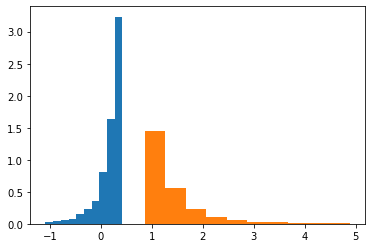

In [51]:
plt.hist(low_cross_post['pmi'], density=True)
plt.hist(high_cross_post['pmi'], density=True)

In [32]:
high_cross_post.describe()

,pmi,label
count,1047.000000,1047.0
mean,-0.012227,1.0
std,0.592346,0.0
min,-0.524956,1.0
25%,-0.410291,1.0
50%,-0.213643,1.0
75%,0.170587,1.0
max,3.496807,1.0


In [53]:
old_crossposting = pd.read_csv("crossposting_full_community_data.csv")

In [52]:
crossposting.to_csv("crossposting_full_community_data_new.csv")

In [55]:
from scipy.stats import spearmanr

In [56]:
spearmanr(old_crossposting['pmi'], crossposting['pmi'])

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [32]:
# sorted_valence = full_df.sort_values(by="Valence")
# sorted_formality = full_df.sort_values(by="Formality")
# sorted_dominance = full_df.sort_values(by="Dominance")
sorted_dominance.tail(20)[['body', "rel_marker", "Valence", "Arousal", "Dominance", "Politeness", "Formality"]]['body'].to_list()

['At his most powerful, Thanos is nearly true omnipotent with the Heart of the Universe.',
 'Would you like to be an Emperor of the Universe?',
 'Also, does it make you sad that you are one of the largest champions of the First Amendment?',
 "It wasn't a tank round, it was an Air to Ground Missile, which is far more impressive.",
 'Mercury is a god... Like immortal, super powerful, direct descendant of the creator of the universe...',
 'However, Starfleet would have a clear technological advantage; the Enterprise alone has more firepower than the death star, which is said to have to have more firepower than the whole star destroyer fleet combined to be able to destroy a planet.',
 'In the bible, God is only omnipotent in one universe iirc while The Presence and TOAA is omnipotent in more than one.',
 'The invading army is going to want to have complete control over all major channels of transportation, so stay off the freeways and highways.',
 "He's the most powerful of all Galactus' s

In [28]:
from scipy.stats import spearmanr

In [29]:
spearmanr(sorted_valence['Valence'], sorted_valence['Politeness'])

SpearmanrResult(correlation=0.4000898013513504, pvalue=0.0)

In [31]:
sorted_valence[sorted_valence["Politeness"] >= 0.8].tail(30)

,author,subreddit,body,created_utc,rel_marker,marker_category,len,Valence,Arousal,Dominance,Politeness,Formality,bin,sub_marker
id,,,,,,,,,,,,,,
cfe2vyl-0,cassiebug1988,iama,"I really thank you, for everything.",1392265553,really,emphatic,6,0.910159,0.475086,0.608468,0.827976,0.493480,V2A1D2P2F2,iama_really
cfdz807-0,cassiebug1988,iama,"I really thank you, for everything.",1392257286,really,emphatic,6,0.910160,0.475086,0.608468,0.827976,0.493480,V2A1D2P2F2,iama_really
ciuxsl4-0,theclassicoversharer,iama,And thank you for creating such amazing works ...,1405118160,amazing,positive_affect_adjective,10,0.910762,0.649609,0.683820,0.818513,0.621179,V2A2D2P2F2,iama_amazing
cn6ofzh-0,tintojohn,techsupport,"Thank you so much, I really appreciate it!!",1419702651,really,emphatic,8,0.910978,0.502385,0.629538,0.842595,0.321893,V2A1D2P2F1,techsupport_really
cli1k0b-1,bookwench,fantasy,Just wanted to say thank you and you're wonder...,1414108857,just,emphatic,9,0.911101,0.621430,0.614391,0.855617,0.417006,V2A2D2P2F2,fantasy_just
ci1k1wp-0,Varzem,mildlyinteresting,Oh god I'm so glad you're back.,1402160203,glad,positive_affect_adjective,7,0.911415,0.559828,0.580759,0.822913,0.067660,V2A1D2P2F1,mildlyinteresting_glad
cjuthi3-0,UnicornApocalypse,videos,This is a fantastic comment and I want to than...,1408475370,want,positive_affect_verbs,13,0.911782,0.522264,0.654282,0.801776,0.595576,V2A1D2P2F2,videos_want
ciy2jzc-6,squaresun,iama,Thank you so much for being such and amazing p...,1405438276,amazing,positive_affect_adjective,10,0.912220,0.445516,0.643493,0.915103,0.423594,V2A1D2P2F2,iama_amazing
cmsnawq-0,Reddittimized,offmychest,"Thank you so much, this really helped.",1418368774,really,emphatic,7,0.912687,0.433835,0.613205,0.801018,0.401008,V2A1D2P2F1,offmychest_really
